In [ ]:
!pip install kagglehub


In [ ]:
import os
from google.colab import files


uploaded = files.upload()


print(uploaded)

filename = list(uploaded.keys())[0]
os.makedirs('/root/.kaggle', exist_ok=True)


!mv "{filename}" /root/.kaggle/kaggle.json


!chmod 600 /root/.kaggle/kaggle.json

print("✅ kaggle.json is ready to use!")


Saving kaggle (1).json to kaggle (1) (2).json
{'kaggle (1) (2).json': b'{"username":"ummsafiyyah","key":"fb645fffcfe70d4eba94b53223b091de"}'}
✅ kaggle.json is ready to use!


In [ ]:


# Download the dataset
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

# Unzip it
!unzip fake-and-real-news-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/41.0M [00:00<?, ?B/s]
100% 41.0M/41.0M [00:00<00:00, 1.07GB/s]
Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [ ]:
import pandas as pd

# Load the CSVs
df_fake = pd.read_csv("Fake.csv")
df_real = pd.read_csv("True.csv")

print("Fake:", df_fake.shape)
print("Real:", df_real.shape)

df_fake.head()


Fake: (23481, 4)
Real: (21417, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
import pandas as pd



# Add a new column to each: 'label'
df_fake['label'] = 0  # 0 = Fake
df_real['label'] = 1  # 1 = Real

# Combine into one DataFrame
df = pd.concat([df_fake, df_real], axis=0).reset_index(drop=True)

print("Combined shape:", df.shape)
df.head()


Combined shape: (44898, 5)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
# Keep only the 'title' and 'label' columns
df = df[['title', 'label']]

# Check for missing titles
print("Missing titles:", df['title'].isnull().sum())

# Drop any rows with missing titles
df.dropna(subset=['title'], inplace=True)

print("Shape after dropping missing:", df.shape)
df.head()


Missing titles: 0
Shape after dropping missing: (44898, 2)


/tmp/ipython-input-9-3953411177.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['title'], inplace=True)


,title,label
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [ ]:
# Check duplicate titles
print("Duplicate titles:", df.duplicated(subset=['title']).sum())

# Drop duplicates
df.drop_duplicates(subset=['title'], inplace=True)

print("Shape after dropping duplicates:", df.shape)


Duplicate titles: 6169
Shape after dropping duplicates: (38729, 2)


label
1    20826
0    17903
Name: count, dtype: int64


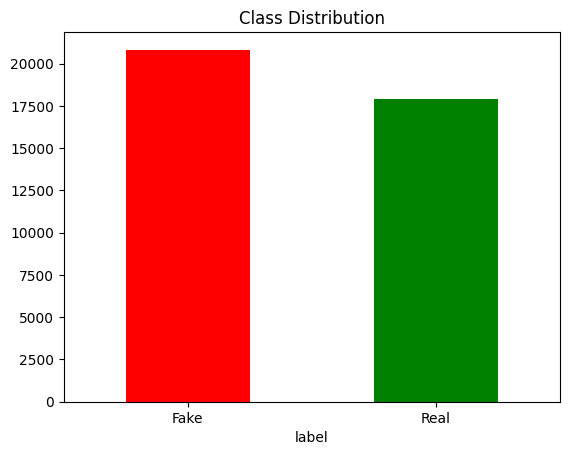

In [ ]:
# Count how many real vs fake
print(df['label'].value_counts())

# Visual check (optional)
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', color=['red','green'])
plt.xticks(ticks=[0,1], labels=['Fake','Real'], rotation=0)
plt.title('Class Distribution')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split data into X (titles) and y (labels)
X = df['title']
y = df['label']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# Create TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit on training data and transform both train and test
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)


Train size: (30983,)
Test size: (7746,)
TF-IDF train shape: (30983, 18995)
TF-IDF test shape: (7746, 18995)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the Multinomial Naive Bayes model
nb = MultinomialNB()

# Train on TF-IDF vectors
nb.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred = nb.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Fake','Real']))


Accuracy: 93.33%

Confusion Matrix:
 [[3319  262]
 [ 255 3910]]

Classification Report:
               precision    recall  f1-score   support

        Fake       0.93      0.93      0.93      3581
        Real       0.94      0.94      0.94      4165

    accuracy                           0.93      7746
   macro avg       0.93      0.93      0.93      7746
weighted avg       0.93      0.93      0.93      7746



In [ ]:
def predict_fake_news(headline):
    # Transform headline using trained vectorizer
    headline_tfidf = vectorizer.transform([headline])

    # Predict
    prediction = nb.predict(headline_tfidf)[0]
    proba = nb.predict_proba(headline_tfidf)[0]

    if prediction == 0:
        label = "Fake"
    else:
        label = "Real"

    print(f"Headline: {headline}")
    print(f"Prediction: {label}")
    print(f"Probability: Fake {proba[0]:.2%}, Real {proba[1]:.2%}")

# Example usage:
predict_fake_news("Aliens have landed on the White House lawn")
predict_fake_news("President addresses the nation on economic growth")


Headline: Aliens have landed on the White House lawn
Prediction: Fake
Probability: Fake 79.29%, Real 20.71%
Headline: President addresses the nation on economic growth
Prediction: Real
Probability: Fake 37.20%, Real 62.80%


In [ ]:
import pickle

# Save Naive Bayes model
with open('model.pkl', 'wb') as f:
    pickle.dump(nb, f)

# Save TF-IDF vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Download to computer
from google.colab import files
files.download('model.pkl')
files.download('vectorizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>